### features:
* selected spectogram coef
* zero crossing rate
* selected chromogram values
* selected tempogram values
* wavelet of level 0

In [1]:
import pandas as pd 
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import auc
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, precision_recall_curve, recall_score
import matplotlib.pyplot as plt
import itertools

In [2]:
csv_path = "/Users/ecem/Desktop/gyrocardiogram/M-15/"

## Load data

Here, our target is to predict disease of patients with multiple diseases. So; our y will be disease column of two column indicatin geach patients disease.

In [3]:
features = pd.read_csv(csv_path + "spectral_features_gyro.csv", index_col = 0)

In [18]:
x_, y_, z_, = [],[],[]
for i in range(15):
    if "x"  in features.columns[i]:
        x_.append(features.columns[i])
    elif "y"  in features.columns[i]:
        y_.append(features.columns[i])
    elif "z"  in features.columns[i]:
        z_.append(features.columns[i])
        

In [19]:
x_

['E x', 'SE x', 'SR x', 'SC x', 'SS x']

In [20]:
features_x = features.loc[:,x_]
features_y = features.loc[:,y_]
features_z = features.loc[:,z_]

In [23]:
features_x

,E x,SE x,SR x,SC x,SS x
0,2.764249,0.618559,0.107031,0.1931,0.239925
1,3.274312,0.618559,0.107031,0.1931,0.239925
2,3.298964,0.618559,0.107031,0.1931,0.239925
3,3.284066,0.618559,0.107031,0.1931,0.239925
4,3.280501,0.618559,0.107031,0.1931,0.239925
...,...,...,...,...,...
2101,3.309207,0.618559,0.107031,0.1931,0.239925
2102,3.275286,0.618559,0.107031,0.1931,0.239925
2103,3.209732,0.618559,0.107031,0.1931,0.239925
2104,3.174726,0.618559,0.107031,0.1931,0.239925


In [57]:
y = np.concatenate( [np.ones((1070)), np.zeros((2017))] )

In [58]:
y

array([1., 1., 1., ..., 0., 0., 0.])

## X

In [59]:
X_train_, X_valid_, y_train_, y_valid_ = train_test_split(features_x, y, train_size=0.8, test_size=0.2,
                                                                random_state=42)

ValueError: Found input variables with inconsistent numbers of samples: [2106, 3087]

In [60]:
import xgboost as xgb
classifier = MultiOutputClassifier(xgb.XGBClassifier(objective = 'binary:logistic'))

clf = Pipeline([('classify', classifier)])


In [27]:
clf.fit(X_train_, y_train_)


Pipeline(steps=[('classify',
                 MultiOutputClassifier(estimator=XGBClassifier(base_score=None,
                                                               booster=None,
                                                               callbacks=None,
                                                               colsample_bylevel=None,
                                                               colsample_bynode=None,
                                                               colsample_bytree=None,
                                                               early_stopping_rounds=None,
                                                               enable_categorical=False,
                                                               eval_metric=None,
                                                               gamma=None,
                                                               gpu_id=None,
                                                               grow_policy=None,
                                                               importance_type=None,
                                                               interaction_constraints=None,
                                                               learning_rate=None,
                                                               max_bin=None,
                                                               max_cat_to_onehot=None,
                                                               max_delta_step=None,
                                                               max_depth=None,
                                                               max_leaves=None,
                                                               min_child_weight=None,
                                                               missing=nan,
                                                               monotone_constraints=None,
                                                               n_estimators=100,
                                                               n_jobs=None,
                                                               num_parallel_tree=None,
                                                               predictor=None,
                                                               random_state=None,
                                                               reg_alpha=None,
                                                               reg_lambda=None, ...)))])

In [28]:
yhat = clf.predict(X_valid_)

In [55]:
yhat.shape

(422, 4)

In [29]:
df_results_test = pd.DataFrame({'AR': y_valid_[:,0], 'AS': y_valid_[:,1], 'MR': y_valid_[:,2], 'MS': y_valid_[:,3],
                        'predicted AR': yhat[:,0],
                          'predicted AS': yhat[:,1],
                          'predicted MR': yhat[:,2], 
                          'predicted MS': yhat[:,3]})
df_results_test

,AR,AS,MR,MS,predicted AR,predicted AS,predicted MR,predicted MS
0,0,0,0,1,1,1,1,0
1,1,1,1,1,1,0,1,0
2,1,1,1,0,0,0,0,0
3,0,1,1,0,0,1,0,0
4,1,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...
417,1,0,0,0,0,1,1,0
418,0,0,1,0,0,1,1,0
419,1,0,0,0,0,0,1,0
420,0,0,1,0,0,0,1,0


In [30]:
auc_y1 = roc_auc_score(y_valid_[:,0],yhat[:,0])
auc_y2 = roc_auc_score(y_valid_[:,1],yhat[:,1])
auc_y3 = roc_auc_score(y_valid_[:,2],yhat[:,2])
auc_y4 = roc_auc_score(y_valid_[:,3],yhat[:,3])

print("ROC AUC AR: %.4f, AS: %.4f, MR: %.4f, MS: %.4f " % (auc_y1, auc_y2, auc_y3, auc_y4))

ROC AUC AR: 0.5032, AS: 0.5267, MR: 0.4916, MS: 0.5436 


In [31]:
weighted_roc_auc_ovo = roc_auc_score(
    y_valid_, yhat, multi_class="ovr", average="weighted"
)

In [32]:
weighted_roc_auc_ovo

0.5109124352686174

In [33]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(y_valid_[:, i], yhat[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_valid_.ravel(), yhat.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


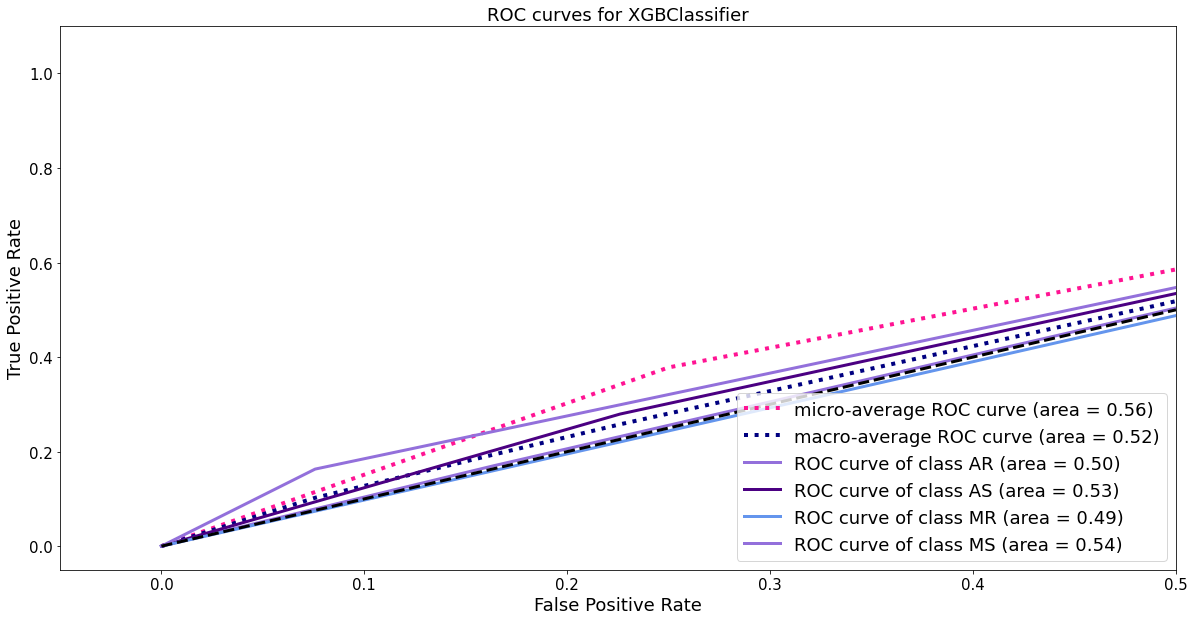

In [34]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(y_valid_[:, i], yhat[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_valid_.ravel(), yhat.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

n_classes = 4
class_names = ["AR", "AS", "MR", "MS"]

from itertools import cycle
lw =3

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize = (20, 10))
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cycle(["mediumpurple", "indigo", "cornflowerblue"])

for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=3,
        label="ROC curve of class {0} (area = {1:0.2f})".format(class_names[i], roc_auc[i]),
    )

plt.plot([0.0, 0.5], [0.0, 0.5], "k--", lw=lw)
plt.xlim([-0.05, 0.5])
plt.xticks(fontsize=15)
plt.ylim([-0.05, 1.1])
plt.yticks(fontsize=15)
plt.xlabel("False Positive Rate",fontsize = 18 )
plt.ylabel("True Positive Rate", fontsize = 18)
plt.title("ROC curves for XGBClassifier",fontsize = 18)
plt.legend(loc="lower right", fontsize = 18) 
plt.show()

In [35]:
cm_y1 = confusion_matrix(y_valid_[:,0],yhat[:,0])
cm_y2 = confusion_matrix(y_valid_[:,1],yhat[:,1])
cm_y3 = confusion_matrix(y_valid_[:,2],yhat[:,2])
cm_y4 = confusion_matrix(y_valid_[:,3],yhat[:,3])
print(cm_y1)



[[225  44]
 [127  26]]


In [36]:
class_dict = {0:'S', 1:'R''}

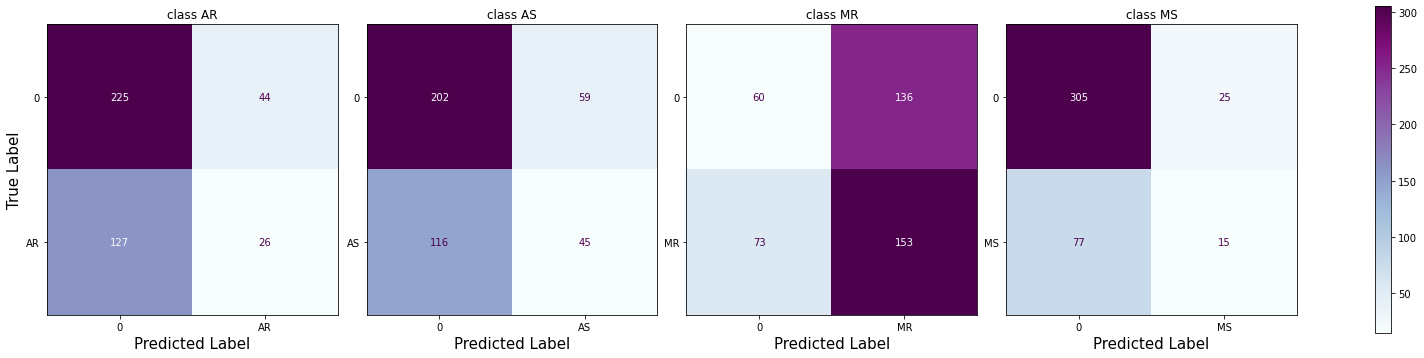

In [37]:
from sklearn.metrics import ConfusionMatrixDisplay

f, axes = plt.subplots(1, 2, figsize=(28, 15))
axes = axes.ravel()
for i in range(2):
    disp = ConfusionMatrixDisplay(confusion_matrix(y_valid_[:, i],
                                                   yhat[:, i]),
                                  display_labels=[0, i])
    if i == 0:
        disp.plot(ax=axes[i], values_format='.4g' , cmap = 'BuPu')
        disp.ax_.set_title(f'class {class_names[i]}')
        disp.ax_.set_xlabel('Predicted Label', fontsize =15)
        disp.ax_.set_ylabel('True Label', fontsize = 15)
        disp.ax_.set_xticklabels([0,class_names[i]])
        disp.ax_.set_yticklabels([0,class_names[i]])
        disp.im_.colorbar.remove()
    else:
        disp.plot(ax=axes[i], values_format='.4g' , cmap = 'BuPu')
        disp.ax_.set_title(f'class {class_names[i]}')
        disp.ax_.set_xlabel('Predicted Label', fontsize =15)
        disp.ax_.set_ylabel(' ')
        disp.ax_.set_xticklabels([0,class_names[i]])
        disp.ax_.set_yticklabels([0,class_names[i]])
        disp.im_.colorbar.remove()
        

plt.subplots_adjust(wspace=0.10, hspace=0.1)
f.colorbar(disp.im_, ax=axes, shrink= 0.4)
plt.show()

In [38]:
cm_y2

array([[202,  59],
       [116,  45]])

In [39]:
cm_y3

array([[ 60, 136],
       [ 73, 153]])

In [40]:
cm_y4

array([[305,  25],
       [ 77,  15]])

In [41]:
cr_y1 = classification_report(y_valid_[:,0],yhat[:,0]) # AR
cr_y2 = classification_report(y_valid_[:,1],yhat[:,1]) # AS
cr_y3 = classification_report(y_valid_[:,2],yhat[:,2]) # MR
cr_y4 = classification_report(y_valid_[:,3],yhat[:,3]) # MS

print (cr_y1)
print (cr_y2)
print (cr_y3)
print (cr_y4)




              precision    recall  f1-score   support

           0       0.64      0.84      0.72       269
           1       0.37      0.17      0.23       153

    accuracy                           0.59       422
   macro avg       0.51      0.50      0.48       422
weighted avg       0.54      0.59      0.55       422

              precision    recall  f1-score   support

           0       0.64      0.77      0.70       261
           1       0.43      0.28      0.34       161

    accuracy                           0.59       422
   macro avg       0.53      0.53      0.52       422
weighted avg       0.56      0.59      0.56       422

              precision    recall  f1-score   support

           0       0.45      0.31      0.36       196
           1       0.53      0.68      0.59       226

    accuracy                           0.50       422
   macro avg       0.49      0.49      0.48       422
weighted avg       0.49      0.50      0.49       422

              preci

## y

In [42]:
X_train, X_valid, y_train, y_valid = train_test_split(features_y, y, train_size=0.8, test_size=0.2,
                                                                random_state=42)

In [43]:
X_train

,E y,SE y,SR y,SC y,SS y
650,1.987539,0.358275,0.021094,0.185179,0.23255
2045,2.253737,0.358275,0.021094,0.185179,0.23255
1939,3.201222,0.358275,0.021094,0.185179,0.23255
1561,3.259981,0.358275,0.021094,0.185179,0.23255
45,3.188259,0.358275,0.021094,0.185179,0.23255
...,...,...,...,...,...
1638,3.291028,0.358275,0.021094,0.185179,0.23255
1095,3.181474,0.358275,0.021094,0.185179,0.23255
1130,3.294987,0.358275,0.021094,0.185179,0.23255
1294,3.100874,0.358275,0.021094,0.185179,0.23255


In [44]:
classifier_f = MultiOutputClassifier(xgb.XGBClassifier(objective = 'binary:logistic'))

clf_f = Pipeline([('classify', classifier)])

clf_f.fit(X_train, y_train)

yhat_f = clf.predict(X_valid)

In [45]:
df_results_test_f = pd.DataFrame({'AR': y_valid[:,0], 'AS': y_valid[:,1], 'MR': y_valid[:,2], 'MS': y_valid[:,3],
                        'predicted AR': yhat_f[:,0],
                          'predicted AS': yhat_f[:,1],
                          'predicted MR': yhat_f[:,2], 
                          'predicted MS': yhat_f[:,3]})
df_results_test_f

,AR,AS,MR,MS,predicted AR,predicted AS,predicted MR,predicted MS
0,0,0,0,1,0,1,1,0
1,1,1,1,1,0,0,0,1
2,1,1,1,0,1,1,1,0
3,0,1,1,0,1,1,1,0
4,1,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...
417,1,0,0,0,1,0,1,0
418,0,0,1,0,0,1,1,0
419,1,0,0,0,1,0,0,0
420,0,0,1,0,0,0,0,0


In [46]:
auc_y1_ = roc_auc_score(y_valid[:,0],yhat_f[:,0])
auc_y2_ = roc_auc_score(y_valid[:,1],yhat_f[:,1])
auc_y3_ = roc_auc_score(y_valid[:,2],yhat_f[:,2])
auc_y4_ = roc_auc_score(y_valid[:,3],yhat_f[:,3])

print("ROC AUC AR: %.4f, AS: %.4f, MR: %.4f, MS: %.4f " % (auc_y1_, auc_y2_, auc_y3_, auc_y4_))

ROC AUC AR: 0.5311, AS: 0.5308, MR: 0.5079, MS: 0.4981 


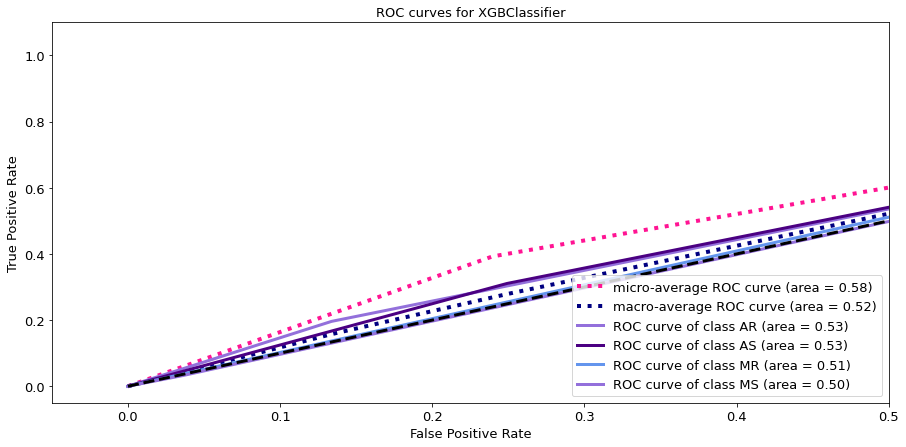

In [47]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(y_valid[:, i], yhat_f[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_valid.ravel(), yhat_f.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

n_classes = 4
class_names = ["AR", "AS", "MR", "MS"]

from itertools import cycle
lw =3

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize = (15, 7))
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cycle(["mediumpurple", "indigo", "cornflowerblue"])

for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=3,
        label="ROC curve of class {0} (area = {1:0.2f})".format(class_names[i], roc_auc[i]),
    )

plt.plot([0.0, 0.5], [0.0, 0.5], "k--", lw=lw)
plt.xlim([-0.05, 0.5])
plt.xticks(fontsize=13)
plt.ylim([-0.05, 1.1])
plt.yticks(fontsize=13)
plt.xlabel("False Positive Rate",fontsize = 13 )
plt.ylabel("True Positive Rate", fontsize = 13)
plt.title("ROC curves for XGBClassifier",fontsize = 13)
plt.legend(loc="lower right", fontsize = 13) 
plt.show()

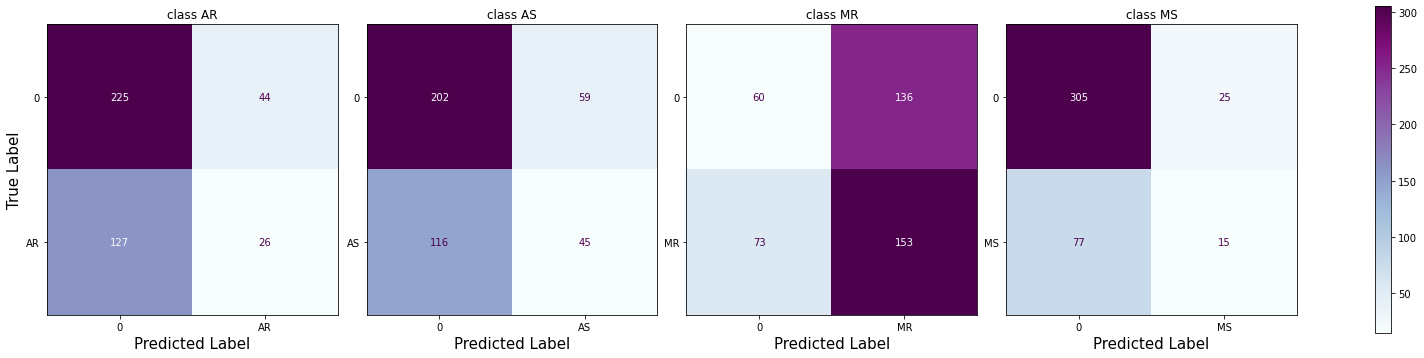

In [48]:
from sklearn.metrics import ConfusionMatrixDisplay

f, axes = plt.subplots(1, 4, figsize=(28, 15))
axes = axes.ravel()
for i in range(4):
    disp = ConfusionMatrixDisplay(confusion_matrix(y_valid_[:, i],
                                                   yhat[:, i]),
                                  display_labels=[0, i])
    if i == 0:
        disp.plot(ax=axes[i], values_format='.4g' , cmap = 'BuPu')
        disp.ax_.set_title(f'class {class_names[i]}')
        disp.ax_.set_xlabel('Predicted Label', fontsize =15)
        disp.ax_.set_ylabel('True Label', fontsize = 15)
        disp.ax_.set_xticklabels([0,class_names[i]])
        disp.ax_.set_yticklabels([0,class_names[i]])
        disp.im_.colorbar.remove()
        
    else:
        disp.plot(ax=axes[i], values_format='.4g' , cmap = 'BuPu')
        disp.ax_.set_title(f'class {class_names[i]}')
        disp.ax_.set_xlabel('Predicted Label', fontsize =15)
        disp.ax_.set_ylabel(' ')
        disp.ax_.set_xticklabels([0,class_names[i]])
        disp.ax_.set_yticklabels([0,class_names[i]])
        disp.im_.colorbar.remove()
      
        

plt.subplots_adjust(wspace=0.10, hspace=0.1)
f.colorbar(disp.im_, ax=axes, shrink= 0.4)

plt.show()

In [49]:
cr_y1_ = classification_report(y_valid[:,0],yhat_f[:,0]) # AR
cr_y2_ = classification_report(y_valid[:,1],yhat_f[:,1]) # AS
cr_y3_ = classification_report(y_valid[:,2],yhat_f[:,2]) #mr
cr_y4_ = classification_report(y_valid[:,3],yhat_f[:,3]) #MS

print (cr_y1_)
print (cr_y2_)
print (cr_y3_)
print (cr_y4_)



              precision    recall  f1-score   support

           0       0.65      0.87      0.75       269
           1       0.45      0.20      0.27       153

    accuracy                           0.62       422
   macro avg       0.55      0.53      0.51       422
weighted avg       0.58      0.62      0.57       422

              precision    recall  f1-score   support

           0       0.64      0.75      0.69       261
           1       0.43      0.31      0.36       161

    accuracy                           0.58       422
   macro avg       0.54      0.53      0.53       422
weighted avg       0.56      0.58      0.57       422

              precision    recall  f1-score   support

           0       0.48      0.29      0.36       196
           1       0.54      0.73      0.62       226

    accuracy                           0.52       422
   macro avg       0.51      0.51      0.49       422
weighted avg       0.51      0.52      0.50       422

              preci

## z

In [50]:
X_train, X_valid, y_train, y_valid = train_test_split(features_z, y, train_size=0.8, test_size=0.2,
                                                                random_state=42)

In [51]:
classifier_f = MultiOutputClassifier(xgb.XGBClassifier(objective = 'binary:logistic'))

clf_f = Pipeline([('classify', classifier)])

clf_f.fit(X_train, y_train)

yhat_f = clf.predict(X_valid)

In [52]:
df_results_test_f = pd.DataFrame({'AR': y_valid[:,0], 'AS': y_valid[:,1], 'MR': y_valid[:,2], 'MS': y_valid[:,3],
                        'predicted AR': yhat_f[:,0],
                          'predicted AS': yhat_f[:,1],
                          'predicted MR': yhat_f[:,2], 
                          'predicted MS': yhat_f[:,3]})
df_results_test_f

,AR,AS,MR,MS,predicted AR,predicted AS,predicted MR,predicted MS
0,0,0,0,1,1,0,0,0
1,1,1,1,1,0,0,1,0
2,1,1,1,0,0,0,0,0
3,0,1,1,0,0,1,1,0
4,1,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...
417,1,0,0,0,0,0,1,0
418,0,0,1,0,0,0,0,1
419,1,0,0,0,0,0,1,0
420,0,0,1,0,0,0,1,0


In [53]:
auc_y1_ = roc_auc_score(y_valid[:,0],yhat_f[:,0])
auc_y2_ = roc_auc_score(y_valid[:,1],yhat_f[:,1])
auc_y3_ = roc_auc_score(y_valid[:,2],yhat_f[:,2])
auc_y4_ = roc_auc_score(y_valid[:,3],yhat_f[:,3])

print("ROC AUC AR: %.4f, AS: %.4f, MR: %.4f, MS: %.4f " % (auc_y1_, auc_y2_, auc_y3_, auc_y4_))

ROC AUC AR: 0.4874, AS: 0.4784, MR: 0.5693, MS: 0.5183 


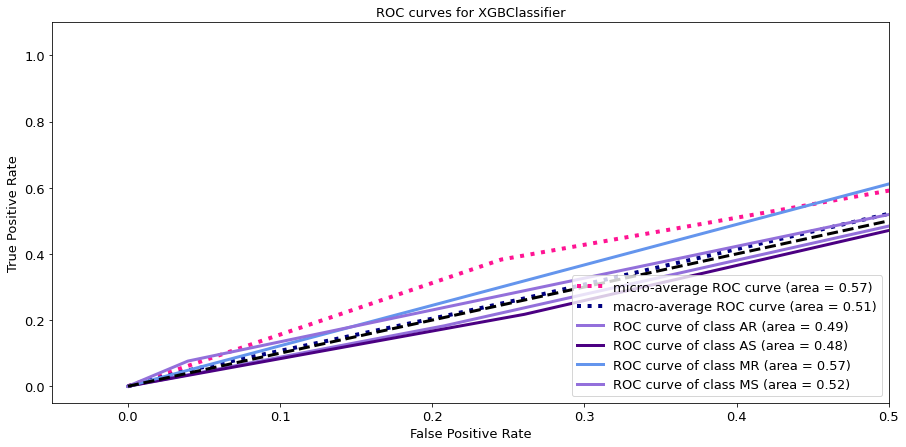

In [54]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(y_valid[:, i], yhat_f[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_valid.ravel(), yhat_f.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

n_classes = 4
class_names = ["AR", "AS", "MR", "MS"]

from itertools import cycle
lw =3

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize = (15, 7))
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cycle(["mediumpurple", "indigo", "cornflowerblue"])

for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=3,
        label="ROC curve of class {0} (area = {1:0.2f})".format(class_names[i], roc_auc[i]),
    )

plt.plot([0.0, 0.5], [0.0, 0.5], "k--", lw=lw)
plt.xlim([-0.05, 0.5])
plt.xticks(fontsize=13)
plt.ylim([-0.05, 1.1])
plt.yticks(fontsize=13)
plt.xlabel("False Positive Rate",fontsize = 13 )
plt.ylabel("True Positive Rate", fontsize = 13)
plt.title("ROC curves for XGBClassifier",fontsize = 13)
plt.legend(loc="lower right", fontsize = 13) 
plt.show()